In [7]:
from pyspark.sql import SparkSession

# New API
spark_session = SparkSession.builder\
        .master("spark://192.168.2.156:7077") \
        .appName("T")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",16)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .config("spark.executor.instances", 1)\
        .config("spark.ui.port", "8082")\
        .getOrCreate()


In [2]:
import time
import psutil
from pyspark.sql.functions import lower, regexp_replace, col, when, count, sum as spark_sum

# Define country list
countries = ["China", "India", "United States", "Indonesia", "Pakistan", 
             "Brazil", "Nigeria", "Bangladesh", "Russia", "Mexico"]

# Step 1) Preprocessing function
def preprocess_data(df):
    # Select only required columns
    df = df.select("subreddit", "body")

    # Handle NULL values (drop if both are NULL, otherwise keep but alter slightly)
    df = df.dropna(how="all", subset=["subreddit", "body"])
    df = df.withColumn("subreddit", when(col("subreddit").isNull(), "unknown").otherwise(col("subreddit")))
    df = df.withColumn("body", when(col("body").isNull(), "").otherwise(col("body")))

    # Convert text to lowercase & remove punctuation
    df = df.withColumn("body", lower(col("body")))
    df = df.withColumn("body", regexp_replace(col("body"), "[^a-zA-Z0-9\s]", ""))

    return df

# Step 2) Country count function
def country_mentions_counter(df):
    for country in countries:
        df = df.withColumn(country, when(col("body").contains(country.lower()), 1).otherwise(0))

    country_mentions = df.groupBy("subreddit").sum(*countries)

    # Summarize total mentions across all subreddits
    total_mentions = country_mentions.select(
        *[spark_sum(col(f"sum({country})")).alias(country) for country in countries]
    )

    return country_mentions, total_mentions

# Step 3) Performance measurement function
def measure_performance(df, dataset_name, metrics_dict):
    """Measure execution time, CPU & memory usage, then store results in a dictionary."""
    
    # Capture system resource usage before execution
    cpu_before = psutil.cpu_percent(interval=None)
    memory_before = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB

    # Measure execution time
    start_time = time.time()
    subreddit_mentions, total_mentions = country_mentions_counter(df)
    end_time = time.time()

    # Capture system resource usage after execution
    cpu_after = psutil.cpu_percent(interval=None)
    memory_after = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB

    # Peak memory usage
    memory_peak = psutil.Process().memory_info().rss / (1024 ** 3)  # Resident Set Size (RSS) in GB

    # Compute execution metrics
    execution_time = end_time - start_time
    cpu_usage = cpu_after - cpu_before
    memory_usage = memory_after - memory_before

    # Store results in dictionary
    metrics_dict[dataset_name] = {
        "Execution Time (s)": execution_time,
        "CPU Usage Change (%)": cpu_usage,
        "Memory Usage Change (GB)": memory_usage,
        "Peak Memory Usage (GB)": memory_peak
    }

    # Show sample output
    total_mentions.show()  # Show total mentions across all subreddits

    print(f"Dataset: {dataset_name}")
    print(f"Execution Time: {execution_time:.4f} seconds")
    #print(f"CPU Usage Change: {cpu_usage:.2f}%")
    #print(f"Memory Usage Change: {memory_usage:.4f} GB")
    #print(f"Peak Memory Usage: {memory_peak:.4f} GB")
    
    return metrics_dict  # Return updated metrics


In [3]:
# Step 4) Performance evaluation loop
metrics_results = {}  # Dictionary to store performance results

dataset_paths = [
    "hdfs://192.168.2.156:9000/data/reddit/reddit_50k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_100k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_200k.json",
    "hdfs://192.168.2.156:9000/data/reddit/reddit_500k.json",
    "hdfs://192.168.2.156:9000/data/reddit/corpus-webis-tldr-17.json", #FULL DATASET
]

for dataset_path in dataset_paths:
    dataset_name = dataset_path.split("/")[-1]  # Extract dataset name
    print(f"\nProcessing dataset: {dataset_name}")

    # Load dataset
    reddit_df = spark_session.read.json(dataset_path)

    # Preprocess data
    reddit_df = preprocess_data(reddit_df)

    # Measure performance & store results
    metrics_results = measure_performance(reddit_df, dataset_name, metrics_results)




Processing dataset: reddit_50k.json


+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|  332|  328|          268|       17|      62|    77|     14|        11|   333|   110|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+

Dataset: reddit_50k.json
Execution Time: 0.2658 seconds

Processing dataset: reddit_100k.json


+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|  689|  690|          528|       56|     114|   147|     34|        18|   702|   240|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+

Dataset: reddit_100k.json
Execution Time: 0.1522 seconds

Processing dataset: reddit_200k.json


+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
| 1406| 1412|         1115|      119|     222|   281|     84|        32|  1413|   492|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+

Dataset: reddit_200k.json
Execution Time: 0.1864 seconds

Processing dataset: reddit_500k.json


+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
| 3585| 3462|         2790|      306|     510|   753|    202|        84|  3397|  1237|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+

Dataset: reddit_500k.json
Execution Time: 0.1181 seconds

Processing dataset: corpus-webis-tldr-17.json


[Stage 29:=====================================================>(146 + 1) / 147]

+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|China|India|United States|Indonesia|Pakistan|Brazil|Nigeria|Bangladesh|Russia|Mexico|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+
|22761|24068|        17899|     1839|    3156|  6238|   1228|       605| 21496|  9070|
+-----+-----+-------------+---------+--------+------+-------+----------+------+------+

Dataset: corpus-webis-tldr-17.json
Execution Time: 0.1072 seconds


/tmp/ipykernel_109600/1517331198.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(metrics_df.index, rotation=45)
/tmp/ipykernel_109600/1517331198.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(metrics_df.index, rotation=45)
/tmp/ipykernel_109600/1517331198.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(metrics_df.index, rotation=45)


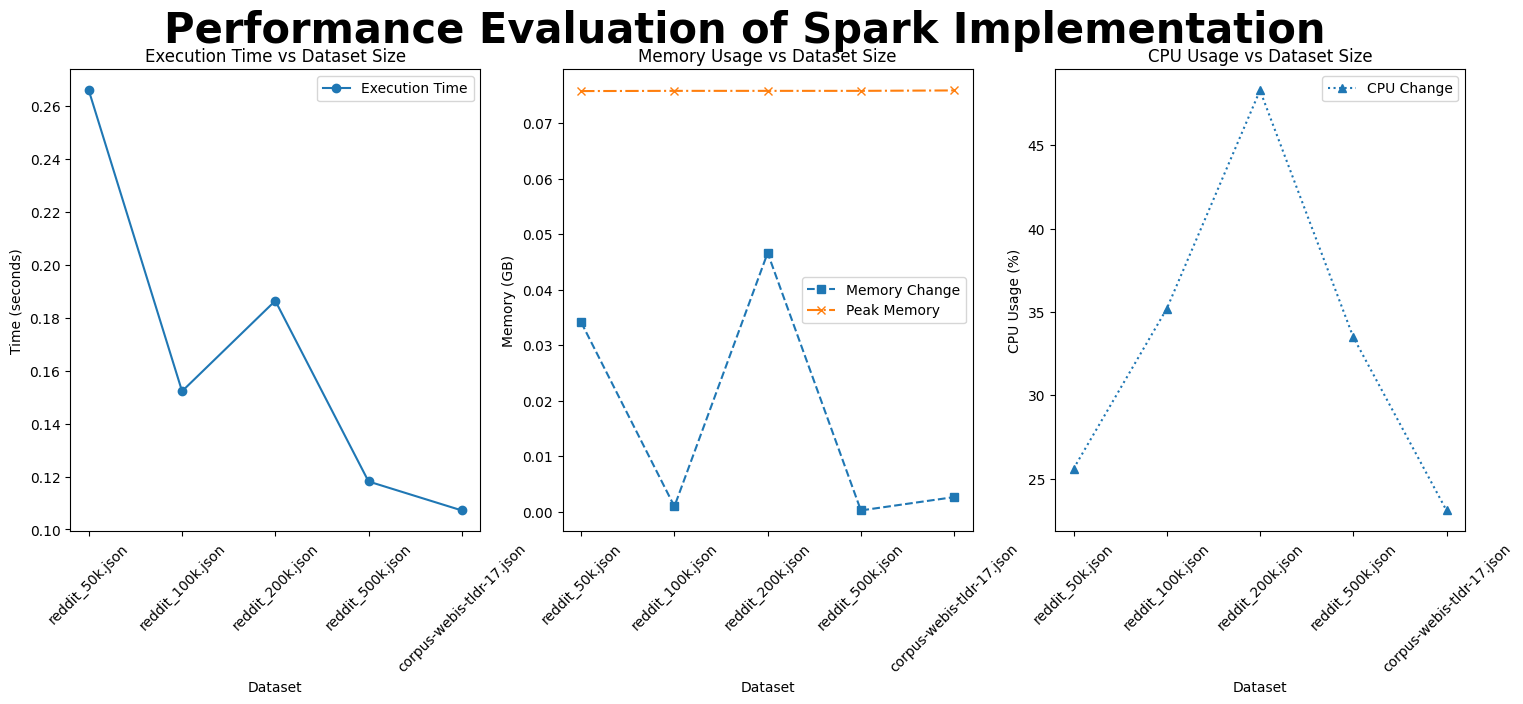

In [9]:
# Step 5) Plotting the result
import pandas as pd
import matplotlib.pyplot as plt

# Convert dictionary to DataFrame
metrics_df = pd.DataFrame.from_dict(metrics_results, orient="index")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
fig.suptitle(r"Performance Evaluation of Spark Implementation", fontsize=30, fontweight='bold')
# Plot execution time vs. dataset size
axes[0].plot(metrics_df.index, metrics_df["Execution Time (s)"], marker="o", linestyle="-", label="Execution Time")
axes[0].set_xlabel("Dataset")
axes[0].set_ylabel("Time (seconds)")
axes[0].set_title("Execution Time vs Dataset Size")
axes[0].legend()
axes[0].set_xticklabels(metrics_df.index, rotation=45)

# Plot memory usage
axes[1].plot(metrics_df.index, metrics_df["Memory Usage Change (GB)"], marker="s", linestyle="--", label="Memory Change")
axes[1].plot(metrics_df.index, metrics_df["Peak Memory Usage (GB)"], marker="x", linestyle="-.", label="Peak Memory")
axes[1].set_xlabel("Dataset")
axes[1].set_ylabel("Memory (GB)")
axes[1].set_title("Memory Usage vs Dataset Size")
axes[1].legend()
axes[1].set_xticklabels(metrics_df.index, rotation=45)

# Plot CPU usage
axes[2].plot(metrics_df.index, metrics_df["CPU Usage Change (%)"], marker="^", linestyle=":", label="CPU Change")
axes[2].set_xlabel("Dataset")
axes[2].set_ylabel("CPU Usage (%)")
axes[2].set_title("CPU Usage vs Dataset Size")
axes[2].legend()
axes[2].set_xticklabels(metrics_df.index, rotation=45)
plt.savefig("Performance_evaluation1.png", dpi=300)
plt.show()

In [10]:
# Terminate session
spark_session.stop()